<a href="https://colab.research.google.com/github/mahdavipanah/IoT-Colab/blob/main/Copy_of_IoT_Colab_(Changing)_(MIN%2BMAX_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to the paper https://www.sciencedirect.com/science/article/pii/S0959652621016267

Link to the slides: https://docs.google.com/presentation/d/1dhO9MWNpegfj3nEEvdvgV3j-j4GoPN5AMzw2mZ3EoIc/edit#slide=id.gf31ab12f31_0_283

Link to the paper's file: https://drive.google.com/file/d/1CokHcR_pmj7ArbuVO3c5RwixoAO8j-q0/view

In [1]:
pip install dataframe-image

     |████████████████████████████████| 1.1 MB 6.2 MB/s 
     |████████████████████████████████| 160 kB 49.0 MB/s 
     |████████████████████████████████| 271 kB 43.8 MB/s 
     |████████████████████████████████| 192 kB 44.0 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import dataframe_image as dfi
import imageio
from pathlib import Path
import os

%load_ext google.colab.data_table

from google.colab import data_table
data_table._DEFAULT_FORMATTERS[float] = lambda x: f"{x:.4f}"

In [9]:
#@title #Parameters

#@markdown Prior knowledge for the probability of the event occurrence:
PE = 0.7#@param {type:"number"}

#@markdown Selection ratio in the list of nodes:
S = 100#@param {type:"integer"}
K = 10#@param {type:"integer"}

#@markdown Number of malicious nodes:
MALICIOUS_NODES_COUNT = 10#@param {type:"integer"}

#@markdown Number of revoked nodes:
REVOKED_NODES_COUNT = 5#@param {type:"integer"}
#@markdown Probability of a revoked node to report a malicious probability:
P_REVOKE_MALICIOUS = 0.7#@param {type:"number"}

#@markdown Trusted nodes probability range (inclusive):
P_START = 0.5#@param {type:"number"}
P_END = 0.99#@param {type:"number"}

#@markdown Malicious nodes probability range (inclusive):
MALICIOUS_P_START = 0.01#@param {type:"number"}
MALICIOUS_P_END = 0.49#@param {type:"number"}

#@markdown Punishment and reward for trust of nodes based on Nash EQ:
TRUST_PUNISH = 0.05#@param {type:"number"}
TRUST_REWARD = 0.03#@param {type:"number"}

#@markdown Maximum and minimum trust:
TRUST_MAX = 0.9#@param {type:"number"}
TRUST_MIN = 0.1#@param {type:"number"}

#@markdown Default Trust:
TRUST_DEFAULT = 0.5#@param {type:"number"}

#@markdown Number of iterations:
ITERATIONS_COUNT = 100#@param {type:"integer"}

#@markdown Indicates weather the code must generate plot image files or not:
GENERATE_PLOT_PNG = False#@param {type:"boolean"}

#@markdown Folder for saving plog pngs (old png files will be removed):
PLOT_PNG_FOLDER = "/content/drive/MyDrive/n-t-plot/pngs"#@param {type:"string"}

#@markdown Plot's variable:
PLOT_VARIABLE = "trust" #@param ["trust", "n_t"]

#@markdown Trust upper and lower bound for plots:
UPPER_BOUND = 0.75#@param {type:"number"}
LOWER_BOUND = 0.3#@param {type:"number"}

#@markdown Default n1 and n2 for sensors:
N1_SENSOR_DEFAULT = 1#@param {type:"integer"}
N2_SENSOR_DEFAULT = 0#@param {type:"integer"}

#@markdown Default duration for sensors:
DURATION_SENSOR_DEFAULT = 0#@param {type:"integer"}

#@markdown Malicious nodes power range:
POWER_MALICIOUS_START = 0.3#@param {type:"number"}
POWER_MALICIOUS_END = 0.6#@param {type:"number"}

#@markdown Non-malicious (trusted and revoked_ nodes power range:
POWER_NON_MALICIOUS_START = 0.7#@param {type:"number"}
POWER_NON_MALICIOUS_END = 0.98#@param {type:"number"}

,probability,power,trust,duration,n1,n2,n_t,N1,N2,trust average,average,cost1,cost2,utility,min utility,max utility,average utility,N_T,total average
0,0.413269,0.553561,0.13,100,32,69,0.316832,694,316,0.592,0.500409,0.007593,0.001778,0.009371,0.009371,0.345757,0.180467,0.687129,0.784
1,0.659850,0.822968,0.90,100,92,9,0.910891,694,316,0.592,0.473011,0.034909,0.224807,0.259716,0.009371,0.345757,0.180467,0.687129,0.784
2,0.610777,0.904830,0.90,100,91,10,0.900990,694,316,0.592,0.478463,0.017507,0.190506,0.208012,0.009371,0.345757,0.180467,0.687129,0.784
3,0.727378,0.893894,0.90,100,92,9,0.910891,694,316,0.592,0.465508,0.068576,0.277181,0.345757,0.009371,0.345757,0.180467,0.687129,0.784
4,0.242383,0.480180,0.13,100,29,72,0.287129,694,316,0.592,0.519396,0.076736,0.119309,0.196045,0.009371,0.345757,0.180467,0.687129,0.784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.802071,0.962672,0.90,100,94,7,0.930693,842,168,0.749,0.637144,0.027201,0.000008,0.027209,0.008970,0.561754,0.097085,0.833663,0.784
96,0.684195,0.824210,0.90,100,99,2,0.980198,842,168,0.749,0.650242,0.001153,0.007817,0.008970,0.008970,0.561754,0.097085,0.833663,0.784
97,0.476759,0.491094,0.13,100,30,71,0.297030,842,168,0.749,0.673290,0.038624,0.189788,0.228412,0.008970,0.561754,0.097085,0.833663,0.784
98,0.732665,0.705949,0.90,100,96,5,0.950495,842,168,0.749,0.644856,0.007710,0.002678,0.010388,0.008970,0.561754,0.097085,0.833663,0.784


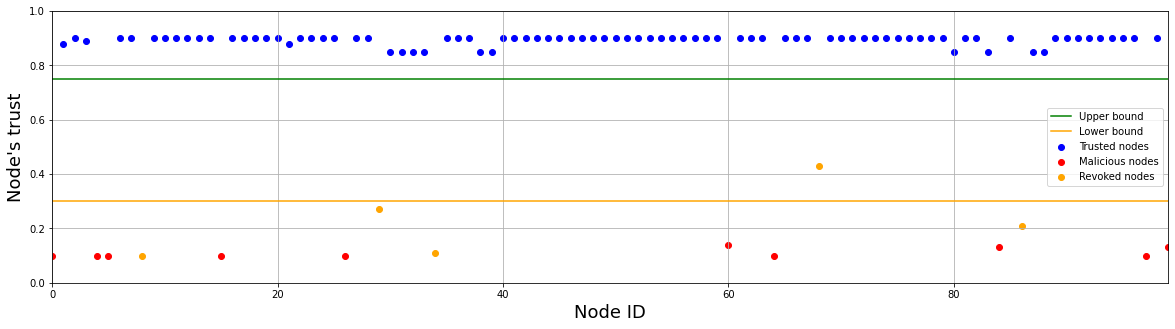

In [14]:
plt.figure(figsize=(20, 5))

rng = np.random.default_rng()

# indices of all nodes
nodes_indices = np.arange(S)
# indices of malicious nodes
malicious_indices = rng.choice(
    nodes_indices,
    size=MALICIOUS_NODES_COUNT,
    replace=False
)
# indices of revoked nodes
revoked_indices = rng.choice(
    np.delete(nodes_indices, malicious_indices),
    size=REVOKED_NODES_COUNT,
    replace=False
)
# indices of trusted nodes
trusted_indices = np.delete(
    nodes_indices,
    np.concatenate([malicious_indices, revoked_indices])
)

total_averages = np.array([])

data_frame = pd.DataFrame()

if GENERATE_PLOT_PNG:
  # remove old pngs plots
  [f.unlink() for f in Path(PLOT_PNG_FOLDER).glob("*.png") if f.is_file()]

plot_list = np.array([])

for iter in np.arange(ITERATIONS_COUNT):
  # trusted nodes probabilities
  trusted_nodes = rng.uniform(
    P_START,
    P_END,
    len(trusted_indices),
  )
  # malicious nodes probabilities
  malicious_nodes = rng.uniform(
    MALICIOUS_P_START,
    MALICIOUS_P_END,
    MALICIOUS_NODES_COUNT,
  )
  # revoked nodes probabilities
  revoked_nodes = np.array([])
  for i in np.arange(REVOKED_NODES_COUNT):
    p_start = p_end = None
    if rng.random() <= P_REVOKE_MALICIOUS:
      p_start, p_end = MALICIOUS_P_START, MALICIOUS_P_END
    else:
      p_start, p_end = P_START, P_END
    
    revoked_nodes = np.append(revoked_nodes,rng.uniform(p_start, p_end))
  
  # malicious nodes powers
  malicious_powers = rng.uniform(
    POWER_MALICIOUS_START,
    POWER_MALICIOUS_END,
    MALICIOUS_NODES_COUNT,
  )

  # non-malicious (trusted and revoked) nodes powers
  non_malicious_powers = rng.uniform(
    POWER_NON_MALICIOUS_START,
    POWER_NON_MALICIOUS_END,
    len(trusted_indices) + REVOKED_NODES_COUNT,
  )

  nodes = np.array([])
  powers = np.array([])
  for i in np.arange(S):
    elem = None
    power = None

    if np.any(np.isin(malicious_indices, i)):
      elem, malicious_nodes = malicious_nodes[0], np.delete(malicious_nodes, 0)
      power, malicious_powers = malicious_powers[0], np.delete(malicious_powers, 0)
    elif np.any(np.isin(revoked_indices, i)):
      elem, revoked_nodes = revoked_nodes[0], np.delete(revoked_nodes, 0)
      power, non_malicious_powers = non_malicious_powers[0], np.delete(non_malicious_powers, 0)
    else:
      elem, trusted_nodes = trusted_nodes[0], np.delete(trusted_nodes, 0)
      power, non_malicious_powers = non_malicious_powers[0], np.delete(non_malicious_powers, 0)

    nodes = np.append(nodes, elem)
    powers = np.append(powers, power)

  data_frame['probability'] = nodes
  data_frame['power'] = powers

  if iter == 0:
    data_frame['trust'] = TRUST_DEFAULT
    data_frame['duration'] = DURATION_SENSOR_DEFAULT
    data_frame['n1'] = N1_SENSOR_DEFAULT
    data_frame['n2'] = N2_SENSOR_DEFAULT
    data_frame['n_t'] = N1_SENSOR_DEFAULT / (
        N1_SENSOR_DEFAULT + N2_SENSOR_DEFAULT
    )
    data_frame['N1'] = 0
    data_frame['N2'] = 0
    data_frame['trust average'] = 0
  
  # generate plot image files
  if GENERATE_PLOT_PNG or iter == ITERATIONS_COUNT - 1:
    plt.clf()
    plt.scatter(
        trusted_indices,
        data_frame.loc[trusted_indices, PLOT_VARIABLE].values,
        color="blue",
        label= 'Trusted nodes',
    )
    plt.scatter(
        malicious_indices,
        data_frame.loc[malicious_indices, PLOT_VARIABLE].values,
        color="red",
        label= 'Malicious nodes',
    )
    plt.scatter(
        revoked_indices,
        data_frame.loc[revoked_indices, PLOT_VARIABLE].values,
        color="orange",
        label= 'Revoked nodes',
    )
    plt.ylim(0, 1)
    plt.xlim(0, S - 1)
    plt.xlabel('Node ID', fontsize=18)
    plt.ylabel("Node's " + PLOT_VARIABLE, fontsize=18)
    plt.axhline(UPPER_BOUND, color="green", label="Upper bound")
    plt.axhline(LOWER_BOUND, color="orange", label="Lower bound")
    plt.grid()
    png_filename = os.path.join(PLOT_PNG_FOLDER, str(iter) + '.png')
    plt.legend()
    plt.savefig(png_filename)
    plot_list = np.append(plot_list, png_filename)

  for n in np.arange(S//K):
    # indecies of the n-th E-Sensor
    sensor_indices = np.arange(n * K, n * K + K)
    
    for i in sensor_indices:
      i_prob = data_frame.at[i, 'probability']

      # indices of other nodes of the sensor
      others_indices = np.delete(
        sensor_indices,
        np.where(sensor_indices == i)
      )

      # average of other nodes of the sensor
      others_average = np.mean(
          data_frame.loc[others_indices, 'probability'].values
      )
      data_frame.at[i, 'average'] = others_average

      # cost1
      i_cost1 = (i_prob - others_average) ** 2
      data_frame.at[i, 'cost1'] = i_cost1
      
      # cost2 calculations
      consistant_t = 1
      non_consistent_t = 1
      
      for j in others_indices:
        j_prob = data_frame.at[j, 'probability']

        condition = (j_prob - 0.5) * (PE - 0.5)
        
        if condition < 0:
          consistant_t *= j_prob
        else:
          non_consistent_t *= j_prob
      
      pi_et = ((PE * consistant_t) /
              (PE * consistant_t + (1 - PE) * non_consistent_t))

      i_cost2 = (i_prob - pi_et) ** 2
      data_frame.at[i, 'cost2'] = i_cost2

      # utility
      data_frame.at[i, 'utility'] = i_cost1 + i_cost2


    # min utility
    argmin = np.min(
        data_frame.loc[sensor_indices, 'utility'].values
    ) 
    data_frame.loc[sensor_indices, 'min utility'] = argmin
    # max utility
    argmax = np.max(
        data_frame.loc[sensor_indices, 'utility'].values
    )
    data_frame.at[sensor_indices, 'max utility'] = argmax
    # average utility
    average = np.mean(
        data_frame.loc[sensor_indices, 'utility'].values
    )
    data_frame.at[sensor_indices, 'average utility'] = average

    th_tail = (argmin + argmax) / 2
    th_head = argmin - (argmin / 2)

    for i in sensor_indices:
      i_prob = data_frame.at[i, 'probability']
      i_trust = data_frame.at[i, 'trust']

      i_new_trust = None

      condition_base = i_prob >= th_head and i_prob <= th_tail
      if condition_base if PE >= 0.5 else not(condition_base):
        # increase sensor's n2
        data_frame.at[i, 'n2'] += 1

        # punish sensor's trust
        if i_trust - TRUST_PUNISH > TRUST_MIN:
          i_new_trust = i_trust - TRUST_PUNISH
        else:
          i_new_trust = TRUST_MIN
      else:
        # increase sensor's n1
        data_frame.at[i, 'n1'] += 1

        # reward sensor's trust
        if i_trust + TRUST_REWARD < TRUST_MAX:
          i_new_trust = i_trust + TRUST_REWARD
        else:
          i_new_trust = TRUST_MAX
      
      data_frame.at[i, 'trust'] = i_new_trust

      data_frame.at[i, 'n_t'] = data_frame.at[i, 'n1'] / (
          data_frame.at[i, 'n1'] + data_frame.at[i, 'n2']
      )

      data_frame.at[i, 'duration'] += 1
    
    # update e-node's N1 and N2
    N1 = data_frame.loc[sensor_indices, 'N1'] = np.sum(
        data_frame.loc[sensor_indices, 'n1'].values
    )
    N2 = data_frame.loc[sensor_indices, 'N2'] = np.sum(
        data_frame.loc[sensor_indices, 'n2'].values
    )
    # update e-node's N_T
    data_frame.loc[sensor_indices, 'N_T'] = N1 / (N1 + N2)

    # update e-node's trust average
    data_frame.loc[sensor_indices, 'trust average'] = np.average(
        data_frame.loc[sensor_indices, 'trust'].values
    )
  
  # total average of the system in each iteration
  total_average = data_frame['total average'] = np.average(
      data_frame['trust'].values
  )

  total_averages = np.append(total_averages, total_average)

data_frame

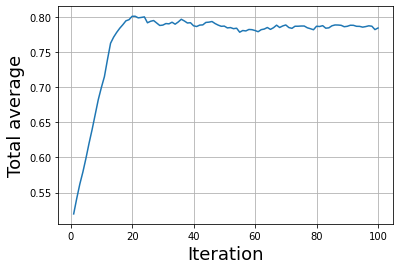

In [35]:
plt.plot(np.arange(1, ITERATIONS_COUNT + 1), total_averages)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel("Total average", fontsize=18)
plt.grid()

In [6]:
import cv2
from pathlib import Path

if GENERATE_PLOT_PNG:
  image_folder = PLOT_PNG_FOLDER
  video_name = 'output.avi'
  video_path = os.path.join(Path(image_folder).parent, video_name)

  images = [
    img for img in os.listdir(image_folder) if img.endswith(".png")
    ]
  images.sort(key=lambda x: int(x[:-4]))
  frame = cv2.imread(os.path.join(image_folder, images[0]))
  height, width, layers = frame.shape

  video = cv2.VideoWriter(video_path, 0, 1, (width,height))

  for image in images:
      video.write(cv2.imread(os.path.join(image_folder, image)))

  cv2.destroyAllWindows()
  video.release()